# Steps für Topic Modeling

# Step 1: Einlesen der bereinigten Daten
# Step 2: Filtern nach Genre 'Rap' und Sprache 'Englisch'
# Step 3: Bereinigung der Texte
# Step 4: Tokenization und Lemmatizer
# Step 5: Stop words
# Step 6: Parameter für Modell bestimmen
# Step 7: LDA Modell anwenden
# Step 8: Topics erkunden
# Step 9: Topics visualisieren


In [3]:
import pandas as pd
from config import data_input_path
import os

In [6]:
df_raw = pd.read_csv(data_input_path)

Batchs of data are randomly loaded in the memory. The number of batchs loaded depends on the memory capacity of the computer running the script. For the analysis, we will only works on the random samples loaded (All the data in Kaggle).  

# Exploring the coarse data

Let's visualize and explore the coarse data before a part of deeper analysis.

In [7]:
df_raw.head()

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
0,Killa Cam,rap,Cam'ron,2004,173166,"{""Cam\\'ron"",""Opera Steve""}","[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1,en,en,en
1,Can I Live,rap,JAY-Z,1996,468624,{},"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3,en,en,en
2,Forgive Me Father,rap,Fabolous,2003,4743,{},Maybe cause I'm eatin\nAnd these bastards fien...,4,en,en,en
3,Down and Out,rap,Cam'ron,2004,144404,"{""Cam\\'ron"",""Kanye West"",""Syleena Johnson""}",[Produced by Kanye West and Brian Miller]\n\n[...,5,en,en,en
4,Fly In,rap,Lil Wayne,2005,78271,{},"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6,en,en,en


For each songs, we've got several informations :
- title of the song
- the tag (genre)
- the artist singer name
- the release year
- the number of page views
- the featuring artists names
- the lyrics
- the genius identifier
- Lyrics language according to [CLD3](https://github.com/google/cld3). Not reliable results are NaN. CLD3 is a neural network model for language indentification.
- Lyrics language according to [FastText's langid](https://fasttext.cc/docs/en/language-identification.html). Values with low confidence (<0.5) are NaN. FastText's langid is library developped by Facebook’s AI Research lab for efficient learning of word representations and sentence classification. fastText has also published a fast and accurate tool for text-based language identification capable of recognizing more than 170 languages.
- Combines language_cld3 and language_ft. Only has a non NaN entry if they both "agree".

In [8]:
df_raw.dtypes

title            object
tag              object
artist           object
year              int64
views             int64
features         object
lyrics           object
id                int64
language_cld3    object
language_ft      object
language         object
dtype: object

In [9]:
# display the size
print('Data frame size (row x columns):', df_raw.size)
print('Data rows number: ', len(df_raw))
print('Number of unique songs (following genius id): ', len(df_raw.id.unique()))

Data frame size (row x columns): 56483416
Data rows number:  5134856
Number of unique songs (following genius id):  5134856


Genius id seems to be the unique rows identifier.

Let's vizualise size of the coarse data over years before preprocessing to compare batch distributions. One things to know before vizualise the data, the pickles are create by chunks reading. 

The last diplayed table gives us some information about the data. The csv file seems to be sort by id, so the pickle files are then sort too.

In [10]:
import os
import pandas as pd
import plotly.express as px

In [ ]:
# get some information about the pickle data
def pickle_informations(loader: Loader):
    rows = []
    for i in range(1, len(os.listdir('data')) + 1):
        df = loader.load_pickle(i)
        rows.append(len(df))
        del df
    return rows

# get the rows
rows = pickle_informations(loader=loader)

# create the dataframe
df_data = pd.DataFrame(
    {'batch' : ['data ' + str(i) for i in range(1,len(rows) + 1)],
    'rows' : rows})

fig = px.bar(df_data, x="batch", y="rows")
fig.show()

Batch seems to have the same number of rows rexcept for the last one which is consistent because batch are create iteratively by 10e6 chunks over the csv The last batch could be seen as a rest.

In [ ]:
from utils.plots import multi_barplot
import plotly.colors as col

# create the color list
colors = col.qualitative.Plotly

# 1990 - 2023
fig1 = multi_barplot(year1=1960, year2=1989, colors=colors, loader=loader)
fig1.show()
# 1960 - 1990
fig2 = multi_barplot(year1=1990, year2=2023, colors=colors, loader=loader)
fig2.show()

The first bar chart (1960 - 1989) shows an increasing numbers of data over years. Moreover batch seems to have quite similar distriutions over years. data_1 and data_2 batch quite outperform the 4 others. data_6 batch is weaker than the other due to its poor number of rows.
The data behaves similarly until 2012 as we can see on the second chart (1990-2023). After this year there is great increasing of the data retrieved. A minimum increase of at least 100% of the batch can be observed. An increase of up to 50 times the batch size for some.

# Data pre-processing

The aim of this part is to preprocess data in order to get suitable data for the analysis. let's focus on the year variable.

We will focus on English songs, to facilitate the analysis and the work of natural language processing algorithms.

In [11]:
# filter by language
df_filtered = df_raw[df_raw.language == 'en']

# filter by genre 
df_filtered = df_filtered[df_filtered.tag == 'rap']

In [12]:
print(f"Num rows: {len(df_filtered)}")

Num rows: 964605


In [13]:
start_year = 1960
end_year = 2024

# filter by year
df_filtered = df_filtered[(df_filtered.year >= start_year) & (df_filtered.year <= end_year)]

In [14]:
print(f"Num rows: {len(df_filtered)}")

Num rows: 963624


In [15]:
# drop nan values
df_filtered = df_filtered.dropna(subset=['lyrics'])

In [16]:
print(f"Num rows: {len(df_filtered)}")

Num rows: 963624


In [17]:
# remove artitst starts with 'Genius'
df_filtered = df_filtered[~df_filtered.artist.str.startswith('Genius')]

In [18]:
print(f"Num rows: {len(df_filtered)}")

Num rows: 959134


In [19]:
# add decade column
df_filtered['decade'] = df_filtered['year'] // 10 * 10

In [20]:
df_filtered.head()

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language,decade
0,Killa Cam,rap,Cam'ron,2004,173166,"{""Cam\\'ron"",""Opera Steve""}","[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1,en,en,en,2000
1,Can I Live,rap,JAY-Z,1996,468624,{},"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3,en,en,en,1990
2,Forgive Me Father,rap,Fabolous,2003,4743,{},Maybe cause I'm eatin\nAnd these bastards fien...,4,en,en,en,2000
3,Down and Out,rap,Cam'ron,2004,144404,"{""Cam\\'ron"",""Kanye West"",""Syleena Johnson""}",[Produced by Kanye West and Brian Miller]\n\n[...,5,en,en,en,2000
4,Fly In,rap,Lil Wayne,2005,78271,{},"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6,en,en,en,2000


In [21]:
# save filtered data
df_filtered.to_csv('data/songs_filtered.csv', index=False)

# Get sample of the data

In [23]:
# check if sample file exists
if os.path.exists('./data/songs_sample.csv'):
    # load sample
    df = pd.read_csv('./data/songs_sample.csv')
else:
    sample_fraction = 0.05  # 5% of the data

    df = df_filtered.sample(frac=sample_fraction, random_state=42)

    # save sample
    df.to_csv('./data/songs_sample.csv', index=False)

# Check if sample is representative

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

df_sample = df

# replace $
df_sample['artist'] = df_sample['artist'].str.replace('$','')

# Verteilungen berechnen
artist_distribution_total = df_filtered['artist'].str.replace('$','').value_counts(normalize=True) * 100
artist_distribution_sample = df_sample['artist'].value_counts(normalize=True) * 100

decade_distribution_total = df_filtered['decade'].value_counts(normalize=True) * 100
decade_distribution_sample = df_sample['decade'].value_counts(normalize=True) * 100

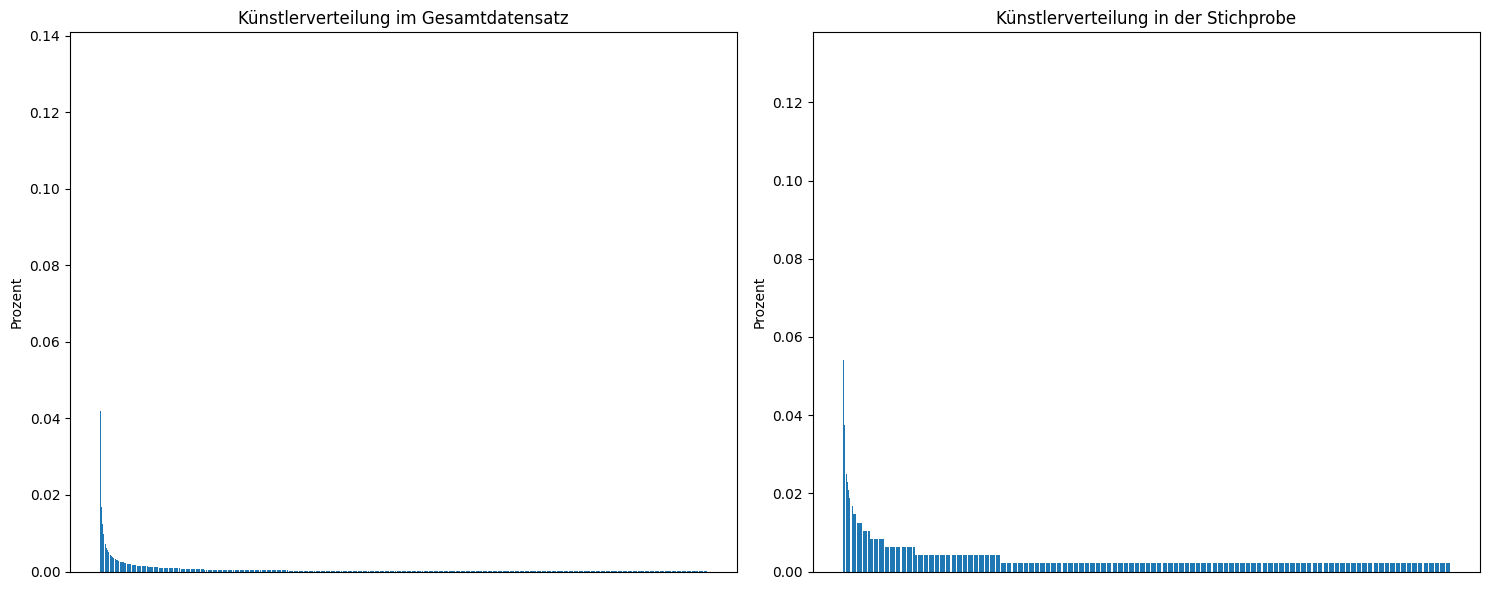

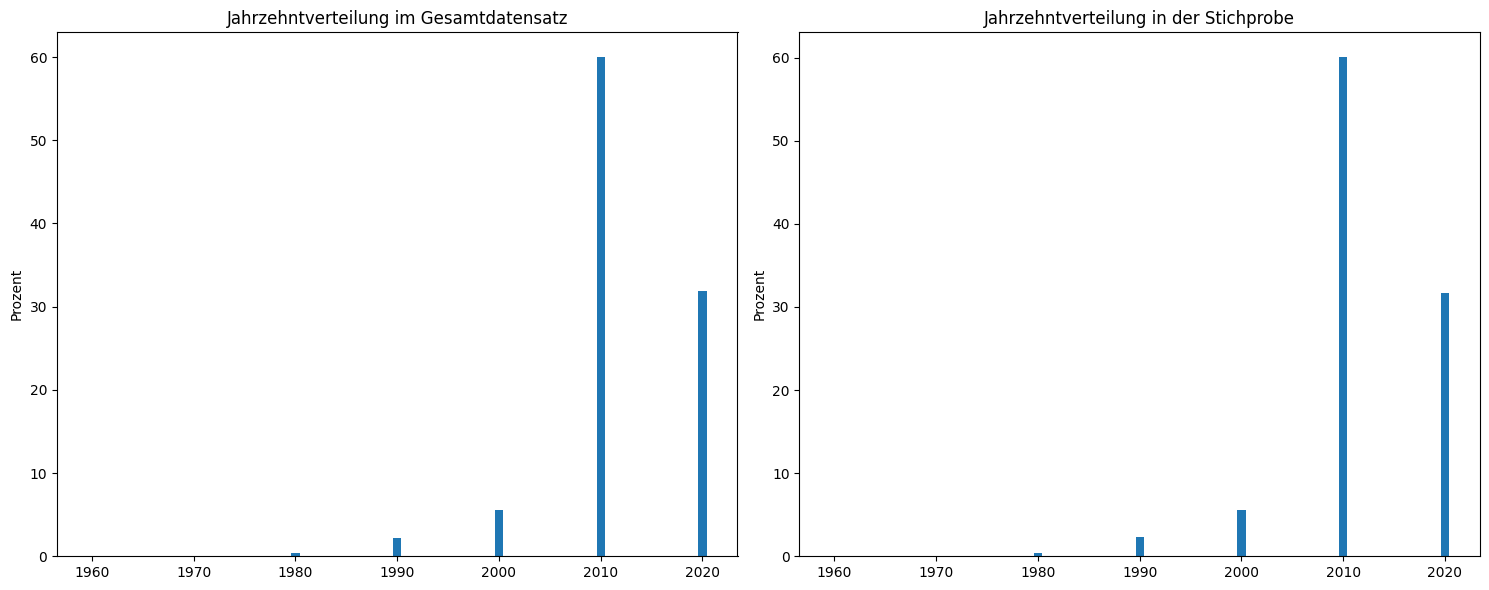

In [33]:
# Erstellen von zwei nebeneinander liegenden Diagrammen für die Künstlerverteilung
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Künstlerverteilung im Gesamtdatensatz (ohne Künstlernamen)
ax1.bar(range(len(artist_distribution_total)), artist_distribution_total.values)
ax1.set_title('Künstlerverteilung im Gesamtdatensatz')
ax1.set_ylabel('Prozent')
ax1.set_xticks([])

# Plot 2: Künstlerverteilung in der Stichprobe (ohne Künstlernamen)
ax2.bar(range(len(artist_distribution_sample)), artist_distribution_sample.values)
ax2.set_title('Künstlerverteilung in der Stichprobe')
ax2.set_ylabel('Prozent')
ax2.set_xticks([])

plt.tight_layout()
plt.savefig('artist_distributions_side_by_side.png')
plt.show()

# Erstellen von zwei nebeneinander liegenden Diagrammen für die Jahrzehntverteilung
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 3: Jahrzehntverteilung im Gesamtdatensatz
ax3.bar(decade_distribution_total.index, decade_distribution_total.values)
ax3.set_title('Jahrzehntverteilung im Gesamtdatensatz')
ax3.set_ylabel('Prozent')

# Plot 4: Jahrzehntverteilung in der Stichprobe
ax4.bar(decade_distribution_sample.index, decade_distribution_sample.values)
ax4.set_title('Jahrzehntverteilung in der Stichprobe')
ax4.set_ylabel('Prozent')

plt.tight_layout()
plt.savefig('decade_distributions_side_by_side.png')
plt.show()

## Clean lyrics

In [34]:
# get the first lyrics
df.iloc[0]["lyrics"]

"[Chorus: Gucci Mane]\nI got an AK, peepin' out the peep hole\nI'm ridin' on Boulder Crest and Flat Shoals\nI’m just a nigga sellin' cheap dope\nCheap cheap cheap cheap, nigga\nI'm in a bando, a house with boarded windows\nI know the feds wanna hit me with the R.I.C.O\nAs soon as you walk in my house you can smell dope\nI'm just anotha nigga from Zone 6 that sell dope\n\n[Verse 1: Playboi Carti]\nAll you see is dope, All you see is dope\nBitch, welcome to my bando, all you see is dope\nA lot of bands on me and I keep the pole\nA lot hoes on me and they gon’ share my pole\nI popped a bean and dirty, missed my styrofoam\nI keep them shooters with me, nigga, whatchu want?\nEvery time time I'm in the bank they be like whatchu want?\nYou know I keep a bad bitch blowin' strong\nYou know I keep a bad bitch money long\nKeep a bad bitch goin' all day long\nMy phone blowin' up, I think they tapped the phone\nDamn, nigga, whatchu want?\n[Chorus: Gucci Mane]\nI got an AK, peepin' out the peep hole

There is many undesirable characters like the line breaker '\n', figures or square, curly and simple brackets. So let's clean this data with regular expressions.

In [35]:
import re
from numpy.random import randint

def clean_text(text):
    # remove \n
    text = text.replace('\n', ' ')
    # remove punctuation
    text = re.sub(r'[,\.!?]', '', text)
    #removing text in square braquet
    text = re.sub(r'\[.*?\]', ' ', text)
    #removing numbers
    text = re.sub(r'\w*\d\w*',' ', text)
    #removing bracket
    text = re.sub(r'[()]', ' ', text)
    # convert all words in lower case
    text = text.lower()
    return text

In [36]:
# get the results of data cleaning
cleaned_text = df["lyrics"].apply(clean_text)

# convert cleaned text to list
docs = cleaned_text.to_list()
docs[0]

"  i got an ak peepin' out the peep hole i'm ridin' on boulder crest and flat shoals i’m just a nigga sellin' cheap dope cheap cheap cheap cheap nigga i'm in a bando a house with boarded windows i know the feds wanna hit me with the rico as soon as you walk in my house you can smell dope i'm just anotha nigga from zone   that sell dope    all you see is dope all you see is dope bitch welcome to my bando all you see is dope a lot of bands on me and i keep the pole a lot hoes on me and they gon’ share my pole i popped a bean and dirty missed my styrofoam i keep them shooters with me nigga whatchu want every time time i'm in the bank they be like whatchu want you know i keep a bad bitch blowin' strong you know i keep a bad bitch money long keep a bad bitch goin' all day long my phone blowin' up i think they tapped the phone damn nigga whatchu want   i got an ak peepin' out the peep hole i'm ridin' on boulder crest and flat shoals i'm just a nigga sellin' cheap dope cheap cheap cheap cheap

In [37]:
# update dataframe
df.update(cleaned_text)
df.head(3)

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language,decade
0,Peepin,rap,Gucci Mane,2015,11905,"{""Playboi Carti"",""21 Savage""}",i got an ak peepin' out the peep hole i'm ri...,2267516,en,en,en,2010
1,Block Boyz,rap,Bo\\Barr & Ocho Savage,2017,127,"{""Bo\\$\\$Barr & Ocho Savage""}",bbg sq-squad squad gang let’s get it bloc...,3275323,en,en,en,2010
2,Fuck CPD,rap,Jordy Rebel,2018,74,{},i’m stuck inside the county and i need someone...,3730460,en,en,en,2010


In [38]:
df.iloc[0]['lyrics']

"  i got an ak peepin' out the peep hole i'm ridin' on boulder crest and flat shoals i’m just a nigga sellin' cheap dope cheap cheap cheap cheap nigga i'm in a bando a house with boarded windows i know the feds wanna hit me with the rico as soon as you walk in my house you can smell dope i'm just anotha nigga from zone   that sell dope    all you see is dope all you see is dope bitch welcome to my bando all you see is dope a lot of bands on me and i keep the pole a lot hoes on me and they gon’ share my pole i popped a bean and dirty missed my styrofoam i keep them shooters with me nigga whatchu want every time time i'm in the bank they be like whatchu want you know i keep a bad bitch blowin' strong you know i keep a bad bitch money long keep a bad bitch goin' all day long my phone blowin' up i think they tapped the phone damn nigga whatchu want   i got an ak peepin' out the peep hole i'm ridin' on boulder crest and flat shoals i'm just a nigga sellin' cheap dope cheap cheap cheap cheap

# Topic modeling

- [LDA (latent dirichlet allocation)](https://fr.wikipedia.org/wiki/Allocation_de_Dirichlet_latente) are the common way to do topic modeling in the few last years, it works and it's quite easy to use with common python library like [Gensim](https://radimrehurek.com/gensim/auto_examples/index.html).

## Define default tokenizer and Lemmatizer

In [96]:
from utils.terms_document_matrix import TermsDocumentsMatrix
from utils.processing import preprocess

set gpu:  False


In [ ]:
# first decades
tdm = TermsDocumentsMatrix(df, decades = [1960, 1970, 1980, 1990],
                           colorscale = 'Plasma')

# display bar charts of most frequent terms
tdm.most_freq_terms(n_rows = 2, n_cols = 2, n_terms = 15)

According to the bar graphs displayed above, a group of words seems to recur on each decade: Love, know, go, feel ... Words that seem to relate to the popular song that can talk about love. This is consistent with our previous analysis from the pie charts showing the proportions of musical styles across time. We also notice an important presence of onomatopoeia like yeah or oh.

In [ ]:
# first decades
tdm = TermsDocumentsMatrix(df, decades = [2000, 2010, 2020],
                          colorscale = 'Plasma')

# most frequent terms
tdm.most_freq_terms(n_rows = 2, n_cols = 2, n_terms = 15)

We get similar results on this second decade with similar high occurrence words. We see a greater amount of onomatopoeia in the current decade. We can explain this by an emergence of the rap music style on this current and last decade. There is in this style of music a very used process, the 'ad-libs'. They are sounds, words or onomatopoeias that the artists pronounce sometimes between two verses or at the end of a sentence to give more impact to their text and to dynamize the atmosphere of a title. This may explain the greater presence of onomatopoeia in the lyrics of this decade.


## Topic modeling with LDA

LDA is a common technic use in topic modeling, we firstly process basic preprocessing.

In [ ]:
import nltk

In [ ]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in df.lyrics])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [ ]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in df.lyrics])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

In [ ]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [ ]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [ ]:
# Filter for bigrams with only noun-type structures
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_word_list = set(stopwords.words('english'))

def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_word_list or bigram[1] in stop_word_list:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_word_list or trigram[-1] in stop_word_list or trigram[1] in stop_word_list:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')
# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 500 ngrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]

filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > 5, axis = 1)][:500]


bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [ ]:
# examples of bigrams
bigrams[:10]

In [ ]:
# examples of trigrams
trigrams[:10]

In [ ]:
# Concatenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

In [ ]:
lyrics_w_ngrams = df.copy()
lyrics_w_ngrams.reviewText = lyrics_w_ngrams.lyrics.map(lambda x: replace_ngram(x))

In [ ]:
# tokenize reviews + remove stop words + remove names + remove words with less than 2 characters
lyrics_w_ngrams = lyrics_w_ngrams.lyrics.map(lambda x: [word for word in x.split()\
                                                 if word not in stop_word_list\
                                                            #   and word not in english_names\
                                                              and len(word) > 2])

In [ ]:
lyrics_w_ngrams.head()

In [ ]:
from gensim import corpora
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords


nltk.download('stopwords')

# Allgemeine Stop-Wörter
common_stop_words = {
    "a", "an", "and", "are", "as", "at", "be", "by", "for", "from", "he", "her",
    "his", "I", "in", "is", "it", "me", "my", "of", "on", "or", "she", "so",
    "that", "the", "to", "up", "was", "we", "with", "you", "i'm", "i've", "i'll", "i'd", "i", "im", "it's", "its", "don't", "dont", "i’m", "i’ve", "i’ll", "i’d", "i", "im", "it’s", "its", "don’t", "dont",
}

# Spezifische Rap-Stop-Wörter
rap_specific_stop_words = {
    "ain't", "yeah", "yea", "yo", "uh", "huh", "gonna", "wanna", "hey", "ooh", "woo",
    "nah", "got", "gotcha", "cuz", "y'all", "imma", "lil", "flex"
}

# Kombiniertes Set von Stop-Wörtern
rap_stop_words = common_stop_words.union(rap_specific_stop_words)

# concatenate the stop words
stop_words = set(stopwords.words('english')).union(rap_stop_words)

# Filter for only nouns
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

def preprocess_lyrics(lyrics):
    return [word for word in lyrics if word not in stop_words]

lyrics = lyrics_w_ngrams.map(preprocess_lyrics)
final_lyrics = lyrics.map(noun_only)
dictionary = corpora.Dictionary(final_lyrics)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_lyrics]



## Calculate coherence score

In [ ]:
import gensim

coherence = []
for k in range(5,25):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=40,\
                   iterations=200, chunksize = 10000, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_lyrics,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

In [ ]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

In [ ]:
from matplotlib import pyplot as plt

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

## Define LDA Model

In [ ]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=19, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

In [ ]:
ldamodel.show_topics(19, num_words=30, formatted=False)

In [ ]:
import pyLDAvis.gensim

topic_data =  pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, mds = 'pcoa', R=10, sort_topics=False)
pyLDAvis.display(topic_data)

In [ ]:
import pandas as pd
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import nltk

# NLTK-Stopwörter herunterladen
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Datenvorverarbeitung und Tokenisierung
def preprocess_lyrics(lyrics):
    return [word for word in simple_preprocess(lyrics) if word not in stop_words]


df['tokens'] = df['lyrics'].apply(preprocess_lyrics)


# Erstelle Wörterbuch und Korpus
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(text) for text in df['tokens']]

# LDA-Modellierung
num_topics = 23
lda_model = LdaModel(
    corpus=corpus, 
    id2word=dictionary, 
    num_topics=num_topics, 
    random_state=42, 
    update_every=1, 
    chunksize=10,
    passes=20, 
    alpha='auto', 
    per_word_topics=True
)

# Themen anzeigen
for idx, topic in lda_model.print_topics(num_words=15):
    print(f"Topic {idx}: {topic}")



In [ ]:
# Visualisierung
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds='mmds', R=15)
pyLDAvis.show(vis, local=False)

# Topic Modeling LDA v2

In [39]:
print("Num of songs: ", len(df))

Num of songs:  47957


In [40]:
from nltk.tokenize import RegexpTokenizer

lyric_corpus_tokenized = []
tokenizer = RegexpTokenizer(r'\w+')
for lyric in df.lyrics:
    tokenized_lyric = tokenizer.tokenize(lyric.lower())
    lyric_corpus_tokenized.append(tokenized_lyric)

In [41]:
# filter all tokens out that are less than 3 characters long
for s,song in enumerate(lyric_corpus_tokenized):
    filtered_song = []    
    for token in song:
        if len(token) > 2 and not token.isnumeric():
            filtered_song.append(token)
    lyric_corpus_tokenized[s] = filtered_song

In [42]:
from nltk.stem.wordnet import WordNetLemmatizer
import nltk

nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
for s,song in enumerate(lyric_corpus_tokenized):
    lemmatized_tokens = []
    for token in song:
        lemmatized_tokens.append(lemmatizer.lemmatize(token))
    lyric_corpus_tokenized[s] = lemmatized_tokens

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/niklasfischer/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [43]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
new_stop_words = ["ooh","yeah","hey","whoa","woah", "ohh", "was", "mmm", "oooh","yah","yeh","mmm", "hmm","deh","doh","jah","wa"]
stop_words.extend(new_stop_words)
for s,song in enumerate(lyric_corpus_tokenized):
    if s % 10_000 == 0:
        print(s)
    filtered_text = []    
    for token in song:
        if token not in stop_words:
            filtered_text.append(token)
    lyric_corpus_tokenized[s] = filtered_text

0
10000
20000
30000
40000


In [47]:
from gensim.corpora import Dictionary
dictionary = Dictionary(lyric_corpus_tokenized)
dictionary.filter_extremes(no_below = 100, no_above = 0.8)

In [48]:
from gensim.corpora import MmCorpus
gensim_corpus = [dictionary.doc2bow(song) for song in lyric_corpus_tokenized]
temp = dictionary[0]
id2word = dictionary.id2token

## Set parameters for LDA

In [63]:
chunksize = 10_000
passes = 20
iterations = 400

In [56]:
# Set up log to external log file
import logging
logging.basicConfig(filename='./logs/lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Calculate coherence scores

Here we determine all coherences of all models with a k between 5 and 24. We will select the parameter k with the highest coherence score

In [64]:
import gensim
import datetime

coherence = []
models = []
for k in range(10,25):
    print('Round: '+str(k))
    print("Creating LDA model")
    print("Time start: ", datetime.datetime.now())

    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(
        corpus=gensim_corpus,
        id2word = dictionary,
        chunksize = chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=k,
        passes=passes,
        eval_every = None,
    )
    
    models.append(ldamodel)
    print("Time end: ", datetime.datetime.now())
    print("Time elapsed: ", datetime.datetime.now() - datetime.datetime.now())
    print("Calculating coherence")
    print("Time start: ", datetime.datetime.now)
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=lyric_corpus_tokenized,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

    print("Time end: ", datetime.datetime.now())
    print("Time elapsed: ", datetime.datetime.now() - datetime.datetime.now())

Round: 10
Creating LDA model
Time start:  2024-08-18 13:14:48.645297
Time end:  2024-08-18 13:20:35.923054
Time elapsed:  0:00:00
Calculating coherence
Time start:  <built-in method now of type object at 0x103ce9bd0>
Time end:  2024-08-18 13:20:56.187242
Time elapsed:  -1 day, 23:59:59.999999
Round: 11
Creating LDA model
Time start:  2024-08-18 13:20:56.187369
Time end:  2024-08-18 13:27:10.489058
Time elapsed:  -1 day, 23:59:59.999996
Calculating coherence
Time start:  <built-in method now of type object at 0x103ce9bd0>
Time end:  2024-08-18 13:27:42.494220
Time elapsed:  -1 day, 23:59:59.999999
Round: 12
Creating LDA model
Time start:  2024-08-18 13:27:42.494356
Time end:  2024-08-18 13:34:17.276416
Time elapsed:  -1 day, 23:59:59.999996
Calculating coherence
Time start:  <built-in method now of type object at 0x103ce9bd0>
Time end:  2024-08-18 13:34:52.588650
Time elapsed:  -1 day, 23:59:59.999999
Round: 13
Creating LDA model
Time start:  2024-08-18 13:34:52.588861
Time end:  2024-0

In [65]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

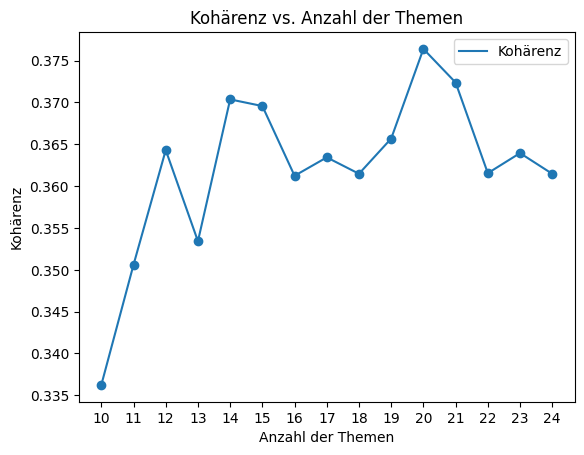

In [67]:
from matplotlib import pyplot as plt

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Kohärenz vs. Anzahl der Themen')
plt.xlabel('Anzahl der Themen')
plt.ylabel('Kohärenz')
plt.xticks(x_val)
plt.legend(['Kohärenz'])
plt.savefig("./plots/number_of_topics_vs_coherence.png")
plt.show()

In [68]:
# get maximum coherence
max_coherence = max(coherence, key=lambda x: x[1])
print(f"Maximum coherence: {max_coherence}")

Maximum coherence: (20, 0.3764046223227254)


## Define LDA Model

In [69]:
# get num of topics with max coherence
num_topics = x_val[y_val.index(max(y_val))]
num_topics

20

In [75]:
load_from_disk = False
load_model_from_coherence = True

from gensim.models import LdaModel
from gensim.test.utils import datapath

model_path = datapath("model")

logging.basicConfig(filename='./logs/lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)
if load_model_from_coherence:
    # get index of highest coherence in coherences list
    lda_index = coherence.index(max_coherence)
    lda_model = models[lda_index]
elif load_from_disk:
    lda_model = LdaModel.load(model_path)
else:
    lda_model = LdaModel(
        corpus=gensim_corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=10,
        passes=passes,
        eval_every=None,
    )

## Get coherence score

In [77]:
from gensim.models.coherencemodel import CoherenceModel
coherencemodel = CoherenceModel(model=lda_model, texts=lyric_corpus_tokenized, dictionary=dictionary, coherence='c_v')
print(coherencemodel.get_coherence())

0.3764046223227254


## Get Perplexity

In [78]:
print('Perplexity: ', lda_model.log_perplexity(gensim_corpus))


Perplexity:  -7.114302149782126


## Generate pyLDAvis

In [80]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
vis_data = gensimvis.prepare(lda_model, gensim_corpus, dictionary)
pyLDAvis.display(vis_data)
# pyLDAvis.save_html(vis_data, f'./visualized/Lyrics_LDA_k_{str(num_topics)}_n_{str(len(df))}.html')

## Save models

In [81]:
from gensim.test.utils import datapath

#saving model to disk.

temp_file = datapath("model")

lda_model.save(temp_file)

In [82]:
temp_file = datapath("coherencemodel")

coherencemodel.save(temp_file)